In [1]:
import os
import sys
import random
import math
import re
import time
import copy
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patches as patches
from sklearn.model_selection import StratifiedShuffleSplit

from config import Config
import utils
import model as modellib
import visualize
from model import log
import seaborn as sns
from visualize import display_images
import skimage
import nuclei
from IPython.core.debugger import set_trace



%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

NUCLEI_DIR = "../../input"

/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
config = nuclei.NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               400
MEAN_PIXEL                     [44.57284587, 40.71265898, 48.6901747]
MINI_MASK_SHAPE                (224, 224)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST

In [3]:
dataset = nuclei.NucleiDataset()
dataset.load_nuclei(NUCLEI_DIR, "train")
dataset.prepare()

dataset_test = nuclei.NucleiDataset()
dataset_test.load_nuclei(NUCLEI_DIR, "test")
dataset_test.prepare()

(512, 640, 3)


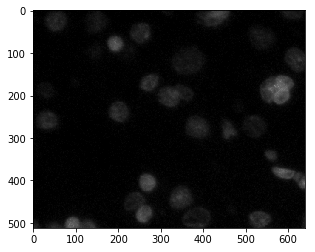

In [8]:
img = dataset.load_image("5d21acedb3015c1208b31778561f8b1079cca7487399300390c3947f691e3974")
print(img.shape)
plt.imshow(img)
# plt.imshow(dataset.load_mask("7b38c9173ebe69b4c6ba7e703c0c27f39305d9b2910f46405993d2ea7a963b80")[0][:,:,0])

In [4]:
data_train, data_val = dataset.extract_train_val()

In [5]:
data_train.prepare()
data_val.prepare()

In [ ]:
img = data_val.load_image("12aeefb1b522b283819b12e4cfaf6b13c1264c0aadac3412b4edd2ace304cb40")
# mask = data_train.load_mask("7b38c9173ebe69b4c6ba7e703c0c27f39305d9b2910f46405993d2ea7a963b80")[0]
print(img.shape)
# print(mask.shape)
plt.imshow(img)

In [21]:
black_white = ["8f94a80b95a881d0efdec36affc915dca9609f4cba8134c4a91b219d418778aa"
"4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381"
"7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770"
"c395870ad9f5a3ae651b50efab9b20c3e6b9aea15d4c731eb34c0cf9e3800a72"
"4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40"
"76a372bfd3fad3ea30cb163b560e52607a8281f5b042484c3a0fc6d0aa5a7450",
"1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df",
"091944f1d2611c916b98c020bd066667e33f4639159b2a92407fe5a40788856d",
"8d05fb18ee0cda107d56735cafa6197a31884e0a5092dc6d41760fb92ae23ab4",
"1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e",
"08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185404ced1dc0866ea992",
"5d58600efa0c2667ec85595bf456a54e2bd6e6e9a5c0dff42d807bc9fe2b822e",
"54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12",
"5e263abff938acba1c0cff698261c7c00c23d7376e3ceacc3d5d4a655216b16d",
"3594684b9ea0e16196f498815508f8d364d55fea2933a2e782122b6f00375d04",
"2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812"]
for real_id in data_val.real_to_id:
    if real_id in black_white:
        print(real_id)

54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12


In [9]:
# imgs = []
# for i in range(len(dataset.image_ids)):
#     img = dataset.load_image(i)
#     if img.shape[-1] != 3:
#         print("image {} has shape {}".format(i,img.shape))
#     imgs.append(img)
#     if i < len(dataset_test.image_ids):
#         img_test = dataset_test.load_image(i)
#         if img_test.shape[-1] != 3:
#             print("image {} has shape {}".format(i,img_test.shape))
#         imgs.append(img_test)
# # f_imgs = np.stack(imgs,axis=0)


In [37]:
# Draw distribution of the number of nuclei in train dataset images
s_masks = []
mask_sh = []
for im_id in range(len(dataset.image_ids)):
    if im_id % 100 == 0: print(im_id)
    # break
    mask = dataset.load_mask(im_id)[0]
    mask_sh.append(mask.shape)

0
100
200
300
400
500
600


In [39]:
mask_sh = [list(m) for m in mask_sh]
nmask_sh = np.stack(mask_sh)

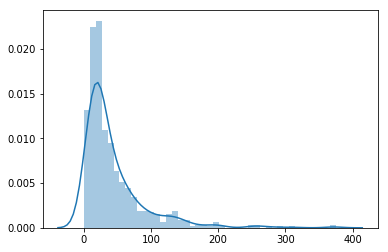

In [11]:
import seaborn as sns
sns.distplot(masks)

In [12]:
np.max(masks)

375

In [10]:
# # Find the mean pixel of the 4 channels of the images in both training and testing.
# # Uncomment all if you didn't do it before. Obtain the value and then put it in
# # config class
# means = []
# for i in range(len(dataset.image_ids)):
#     if i < len(dataset_test.image_ids):
#         img_test = dataset_test.load_image(i)
#         mean_test = np.mean(img_test, axis=(0,1))
#         if img_test.shape[-1] != 4:
#             print("Test Image {} has {} dimensions".format(
#             i, img_test.shape))
#             mean_test = np.append(mean_test, [255.])
#         means.append(mean_test)
#     img_train = dataset.load_image(i)
#     if img_train.shape[-1] != 4:
#         print("Train Image {} has {} dimensions".format(
#         i, img_train.shape))
#     mean_train = np.mean(img_train, axis=(0,1))
#     means.append(mean_train)

# all_means = np.stack(means, axis=0)
# np.mean(all_means,axis=0)

276

(260, 347)


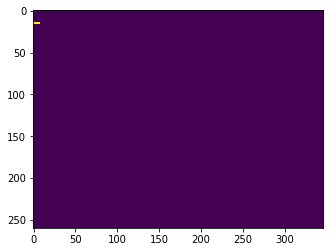

In [11]:
# Display troublesome images
trouble = "7b38c9173ebe69b4c6ba7e703c0c27f39305d9b2910f46405993d2ea7a963b80"
for i in range(len(dataset.image_ids)):
    if dataset.image_info[i]['id'] == trouble:
        print(i)
        img = dataset.load_image(i)
        mask, class_ids = dataset.load_mask(i)
plt.imshow(img)
m = mask[:, :, np.where(class_ids == 1)[0]]
print()
m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
print(m.shape)
plt.imshow(m)

In [8]:
print("Image Count: {}".format(len(data_val.image_ids)))
print("Class Count: {}".format(data_val.num_classes))
for i, info in enumerate(data_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 4
Class Count: 2
  0. BG                                                
  1. nu                                                


## Display Samples

Load and display images and masks.

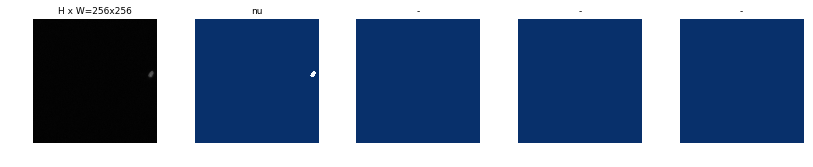

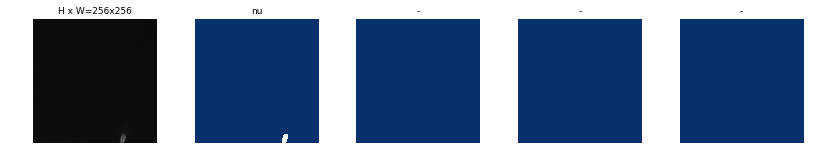

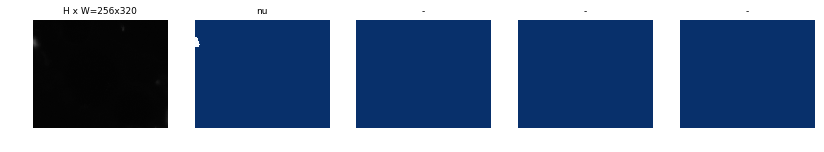

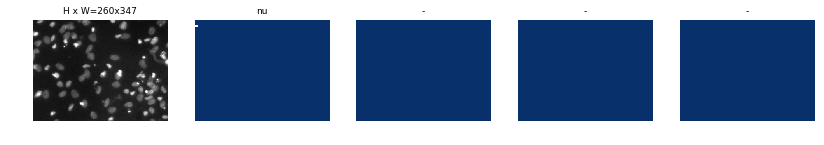

In [31]:
# Load and display random samples
# image_ids = list(np.random.choice(dataset.image_ids, 3))
# image_ids.append("5d21acedb3015c1208b31778561f8b1079cca7487399300390c3947f691e3974")
# image_ids = np.append(image_ids, ["5d21acedb3015c1208b31778561f8b1079cca7487399300390c3947f691e3974"])
# image_ids = [302, 342, 350, 25, 1, 39]
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [6]:
b_masks = open("bad_masks", "r") 
b_lines = b_masks.readlines()
b_masks = (m for m in b_lines)

In [91]:
b_mask = next(b_masks)
_, image_id, _, mask_id = b_mask.split("\\")
mask_id = mask_id[:-5]

(256, 256, 3)
(256, 256, 1)
(1,)


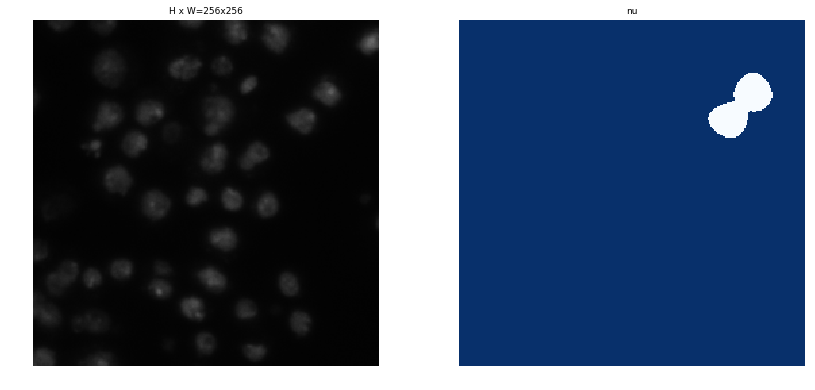

In [92]:
# image_id = "ef3ef194e5657fda708ecbd3eb6530286ed2ba23c88efb9f1715298975c73548"
# mask_id = "9d2eb605a9e1b87b213cf0d2a366e461049cac5942db4b1a40a967dd54417792"
image = dataset.load_image(image_id)
mask = dataset.load_mask(image_id, mask_id)[0]
mask = mask[:,:,None]
class_id = np.array([1],dtype=np.int32)
print(image.shape)
print(mask.shape)
print(class_id.shape)
# mask, class_id = dataset.load_mask(image_id)
visualize.display_top_masks(image, mask, class_id, dataset.class_names, limit=1)
# # plt.imshow(image)

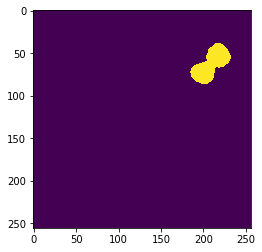

In [99]:
# mask = mask[:,:,0]
# from scipy import ndimage
# labels, nlabels = ndimage.label(mask)
plt.imshow(mask)

In [107]:
cell_indices = ndimage.find_objects(labels)[0]

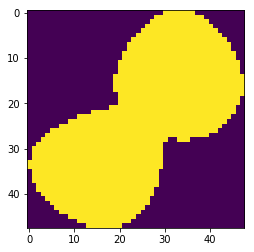

In [108]:
plt.imshow(mask[cell_indices])

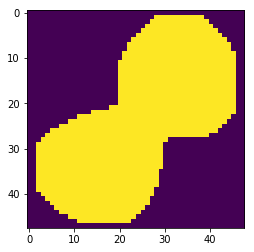

In [136]:
kernel = np.ones((3,3),np.uint8)
cell_mask_opened = ndimage.binary_opening(mask[cell_indices],iterations=, structure=kernel)
plt.imshow(cell_mask_opened)

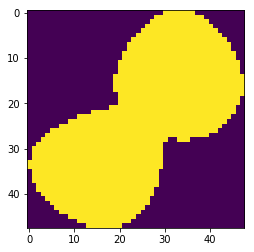

In [116]:
plt.imshow(cell_mask_opened)

In [58]:
print(ndimage.binary_opening.__doc__)


    Multi-dimensional binary opening with the given structuring element.

    The *opening* of an input image by a structuring element is the
    *dilation* of the *erosion* of the image by the structuring element.

    Parameters
    ----------
    input : array_like
        Binary array_like to be opened. Non-zero (True) elements form
        the subset to be opened.
    structure : array_like, optional
        Structuring element used for the opening. Non-zero elements are
        considered True. If no structuring element is provided an element
        is generated with a square connectivity equal to one (i.e., only
        nearest neighbors are connected to the center, diagonally-connected
        elements are not considered neighbors).
    iterations : {int, float}, optional
        The erosion step of the opening, then the dilation step are each
        repeated `iterations` times (one, by default). If `iterations` is
        less than 1, each operation is repeated until the re

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

image_id  15 ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5f5dd2ddfe5407007ee
image                    shape: (1024, 1024, 3)       min:   42.00000  max:  244.00000
mask                     shape: (1024, 1024, 73)      min:    0.00000  max:  255.00000
class_ids                shape: (73,)                 min:    1.00000  max:    1.00000
bbox                     shape: (73, 4)               min:    0.00000  max: 1024.00000


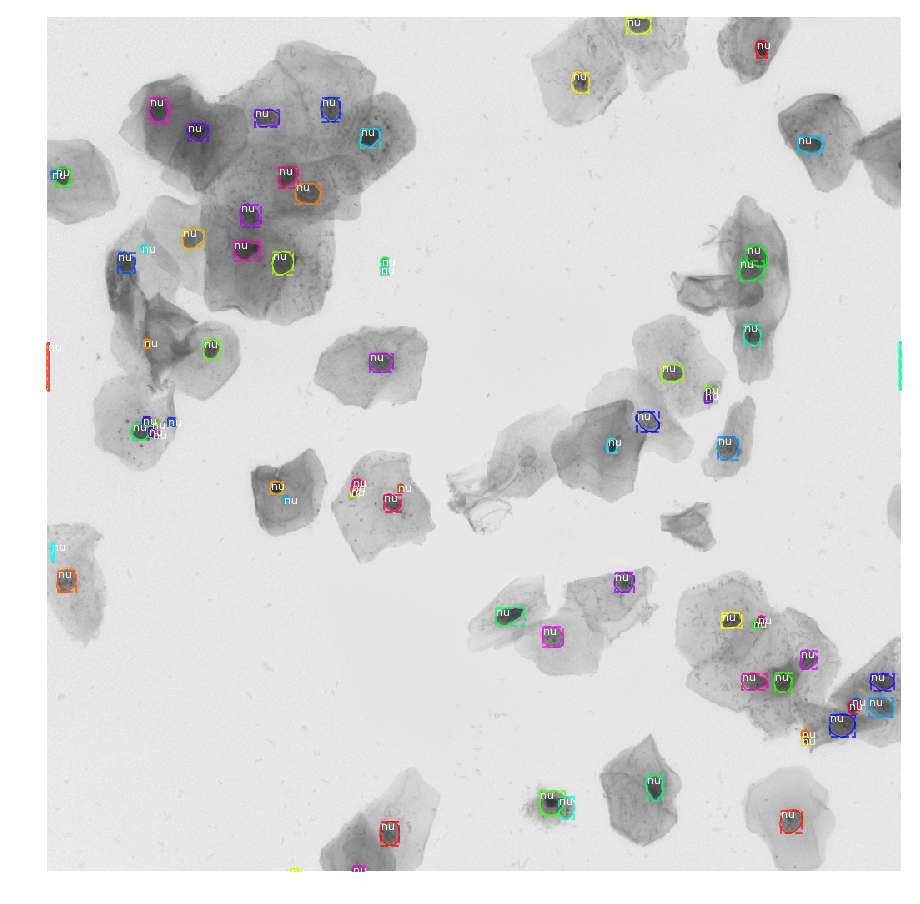

In [19]:
# Load random image and mask.
# image_id = random.choice(dataset.image_ids)
image_id = 15
image = data_val.load_image(image_id)
mask, class_ids = data_val.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_info[image_id]['id'])
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

image_id:  0 
Original shape:  (520, 696, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  233.00000
mask                     shape: (1024, 1024, 183)     min:    0.00000  max:  255.00000
class_ids                shape: (183,)                min:    1.00000  max:    1.00000
bbox                     shape: (183, 4)              min:    0.00000  max: 1023.00000


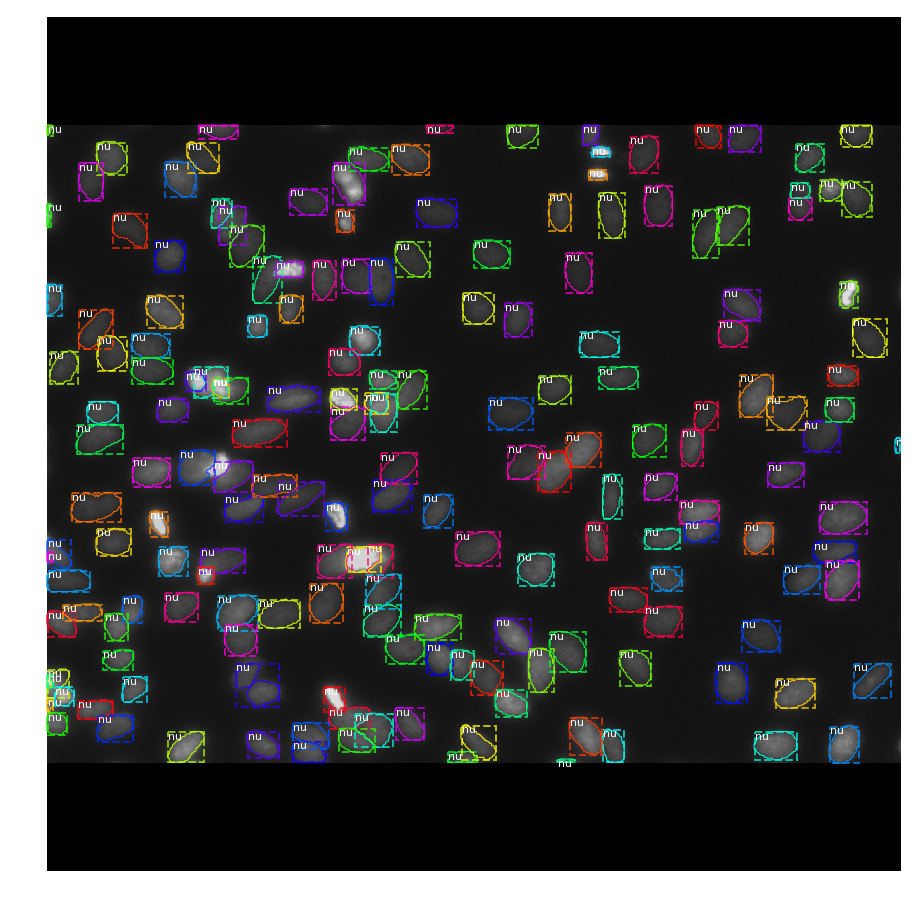

In [7]:
# Load random image and mask.
# image_id = np.random.choice(dataset.image_ids, 1)[0]
image_id = 0
image = data_val.load_image(image_id)
mask, class_ids = data_val.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    padding=config.IMAGE_PADDING)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, data_val.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, data_val.class_names)

## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks by:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

image                    shape: (1024, 1024, 3)       min:   42.00000  max:  244.00000
image_meta               shape: (10,)                 min:    0.00000  max: 1024.00000
class_ids                shape: (73,)                 min:    1.00000  max:    1.00000
bbox                     shape: (73, 4)               min:    0.00000  max: 1024.00000
mask                     shape: (1024, 1024, 73)      min:    0.00000  max:  255.00000


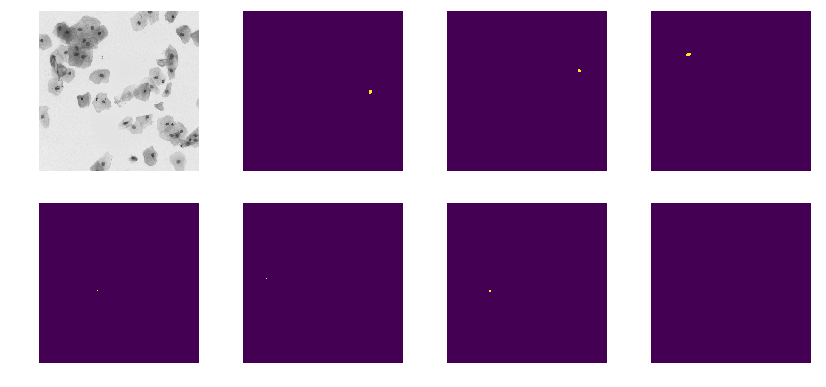

In [15]:
image_id = 15
# image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    data_val, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

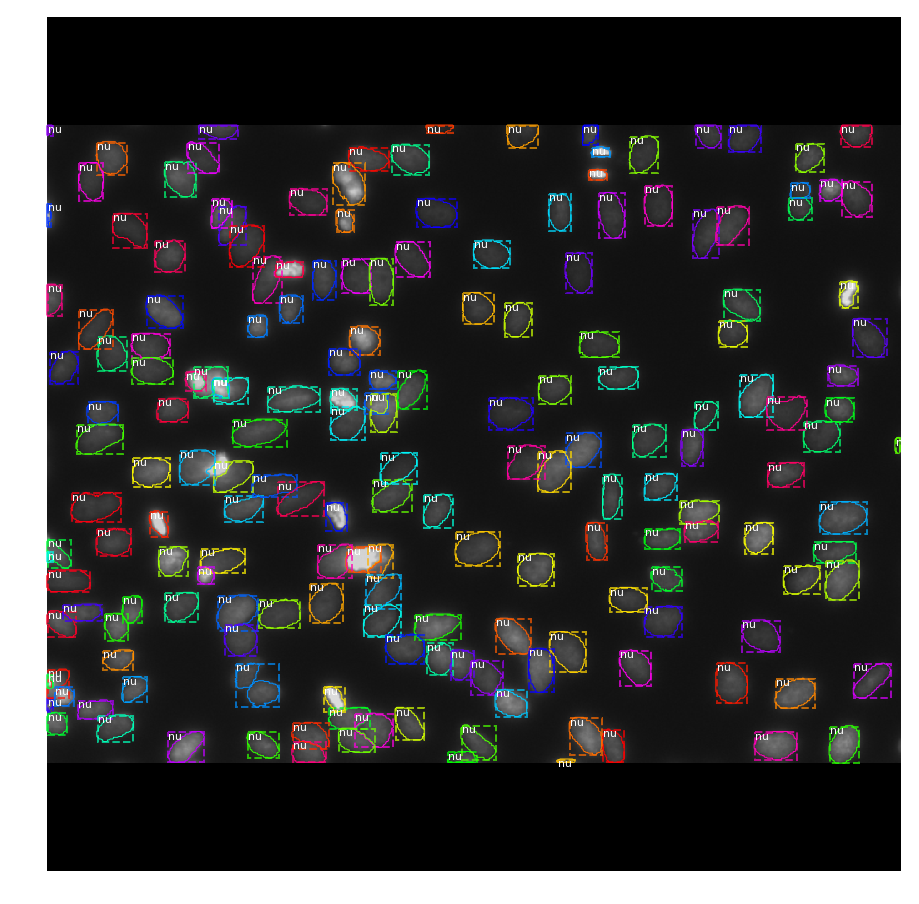

In [9]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image                    shape: (1024, 1024, 3)       min:   42.00000  max:  244.00000
image_meta               shape: (10,)                 min:    0.00000  max: 1024.00000
class_ids                shape: (73,)                 min:    1.00000  max:    1.00000
bbox                     shape: (73, 4)               min:    0.00000  max: 1024.00000
mask                     shape: (56, 56, 73)          min:    0.00000  max:    1.00000


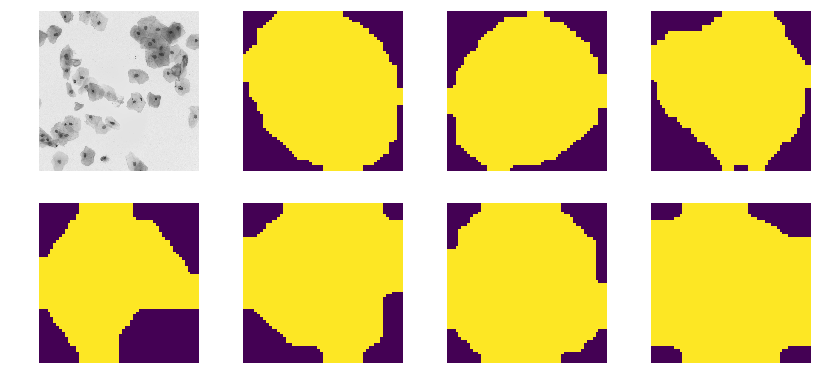

In [18]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    data_val, config, image_id, augment=True, use_mini_mask=True)
log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

(1024, 1024, 183)


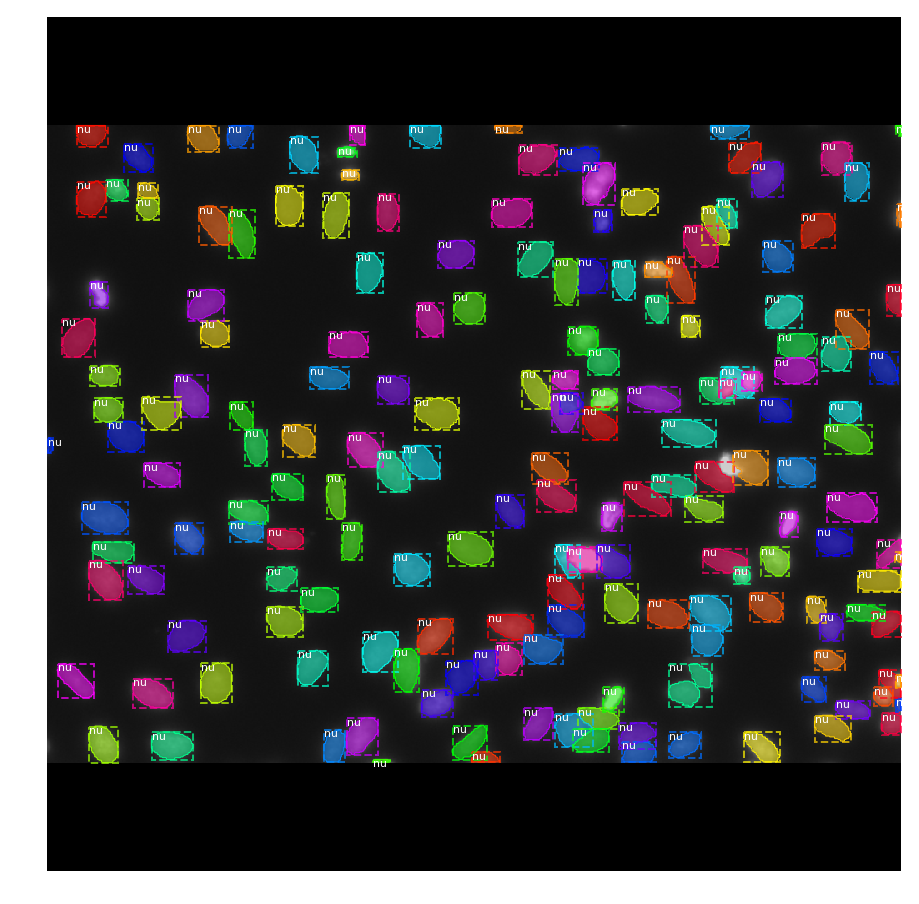

In [11]:
mask = utils.expand_mask(bbox, mask, image.shape)
print(mask.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [12]:
# Generate Anchors
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          config.BACKBONE_SHAPES,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)
print(anchors.shape)
# Print summary of anchors
num_levels = len(config.BACKBONE_SHAPES)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = config.BACKBONE_SHAPES[l][0] * config.BACKBONE_SHAPES[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

(261888, 4)
Count:  261888
Scales:  (16, 32, 64, 128, 256)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


Visualize anchors of one cell at the center of the feature map of a specific level.

Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


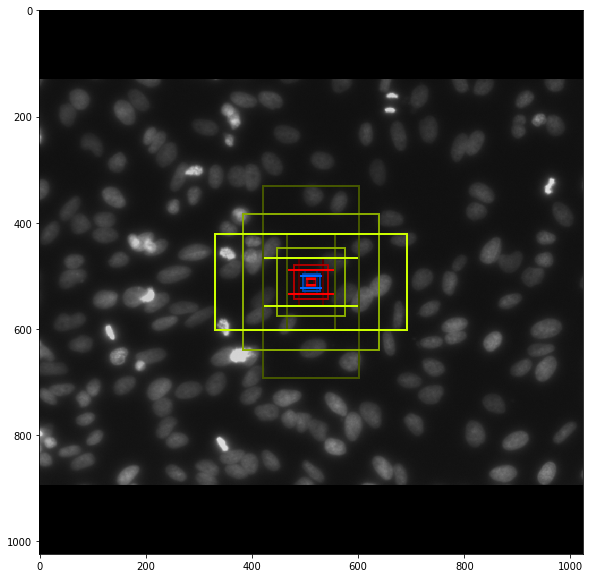

In [13]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
# image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(data_val, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(config.BACKBONE_SHAPES)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    # from IPython.core.debugger import Tracer; Tracer()()
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                config.BACKBONE_SHAPES[level]))
    center_cell = config.BACKBONE_SHAPES[level] // 2
    center_cell_index = (center_cell[0] * config.BACKBONE_SHAPES[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * config.BACKBONE_SHAPES[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator

In [14]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    data_val, config, shuffle=False, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)
# next(g)

In [18]:
# # Uncomment to run the generator through a lot of train images
# # to catch rare errors
# for i in range(len(dataset.image_ids)):
#     print(i)
#     _, _ = next(g)
# # config.RPN_TRAIN_ANCHORS_PER_IMAGE

Checkout image 49. It gives the error:
```
/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
```
See if you can solve it. And why it's giving this.


In [15]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = image_meta[0][0]
print("image_id: ", image_id, data_val.image_info[image_id]['id'])

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 512, 4)           min:    0.00000  max: 1023.00000
mrcnn_class_ids          shape: (4, 512, 1)           min:    0.00000  max:    1.00000
mrcnn_bbox               shape: (4, 512, 2, 4)        min:   -3.19244  max:    3.26087
mrcnn_mask               shape: (4, 512, 28, 28, 2)   min:    0.00000  max:    1.00000
gt_class_ids             shape: (4, 400)              min:    0.00000  max:    1.00000
gt_boxes                 shape: (4, 400, 4)           min:    0.00000  max: 1024.00000
gt_masks                 shape: (4, 56, 56, 400)      min:    0.00000  max:    1.00000
rpn_match                shape: (4, 261888, 1)        min:   -1.00000  max:    1.00000
rpn_bbox                 shape: (4, 256, 4)           min:   -6.63701  max:    3.28125
image_id:  0 4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9


In [20]:
print(normalized_images.shape)

(4, 1024, 1024, 3)


anchors                  shape: (261888, 4)           min: -181.01934  max: 1141.01934
refined_anchors          shape: (128, 4)              min:   35.00000  max: 1024.00000
Positive anchors: 128
Negative anchors: 128
Neutral anchors: 261632
BG                     : 475
nu                     : 37


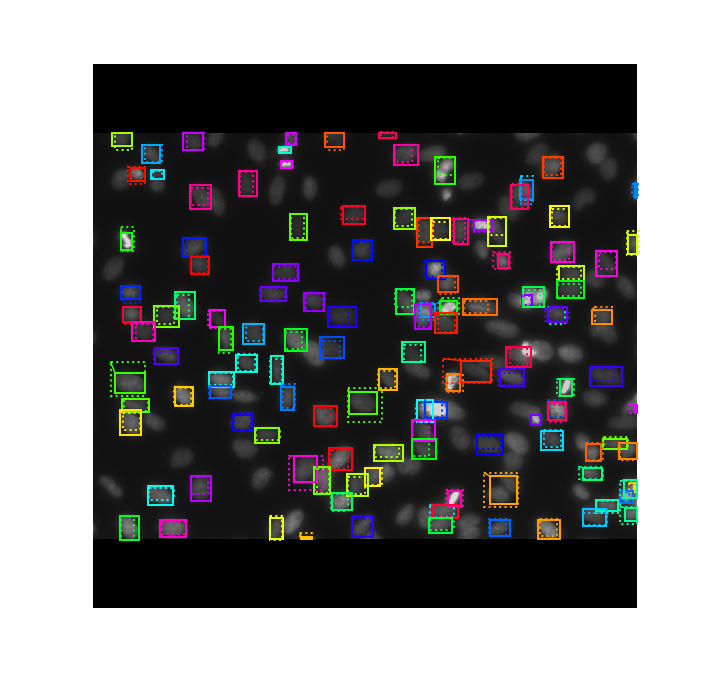

In [16]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)


# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)


# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

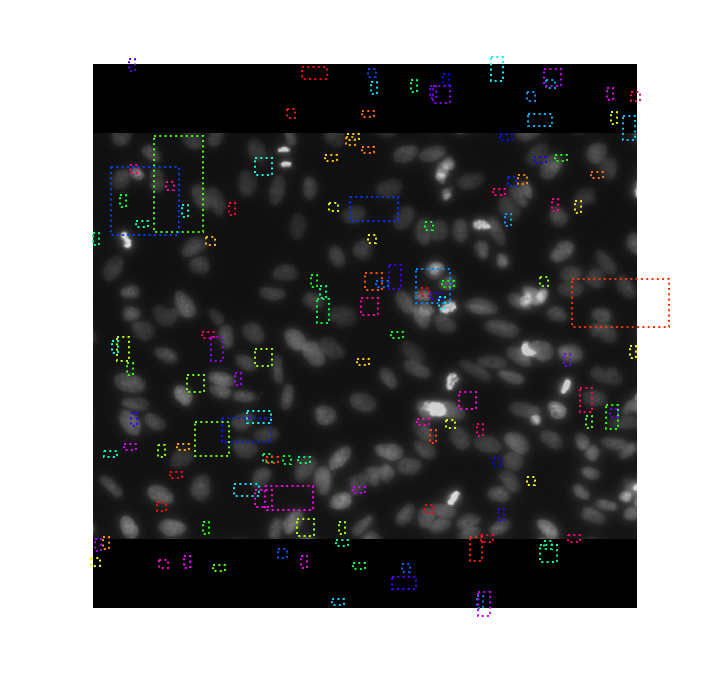

In [23]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

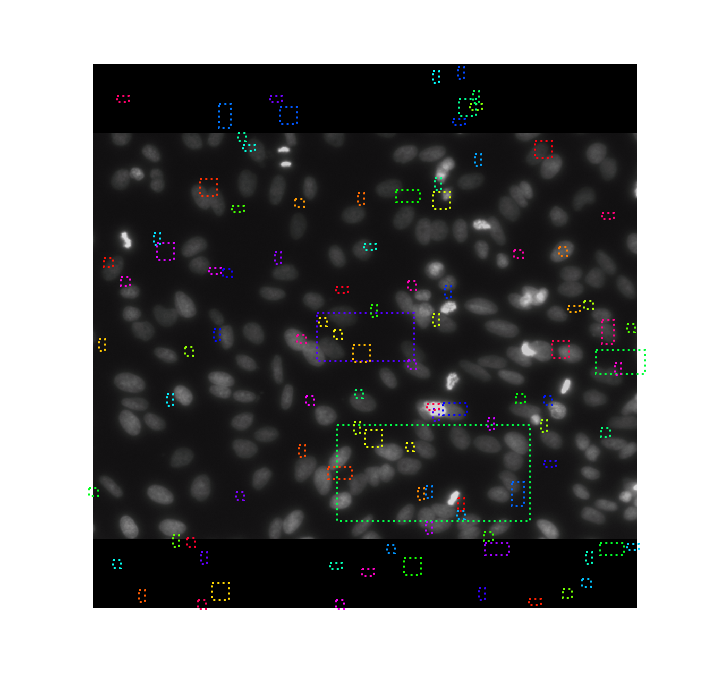

In [24]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  18
Negative ROIs:  494
Positive Ratio: 0.04
Unique ROIs: 512 out of 512


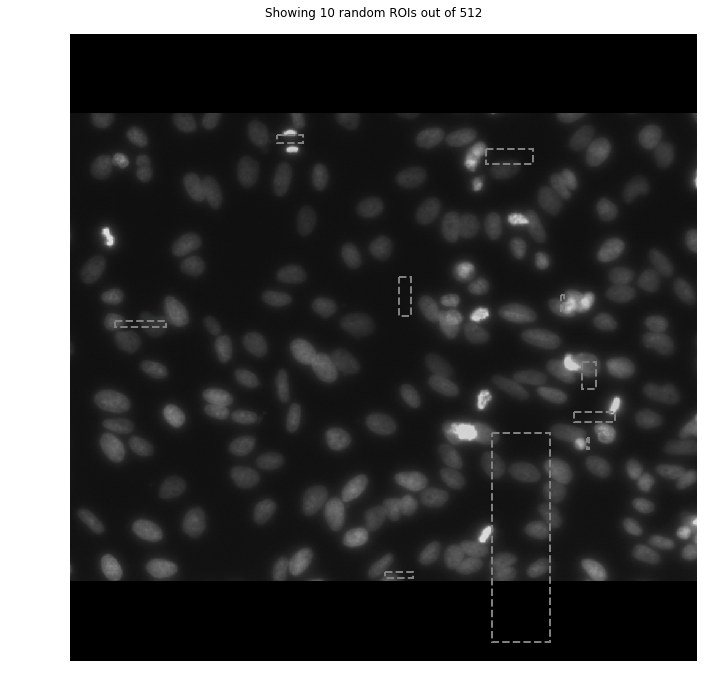

In [25]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]
    
    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]
    
    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

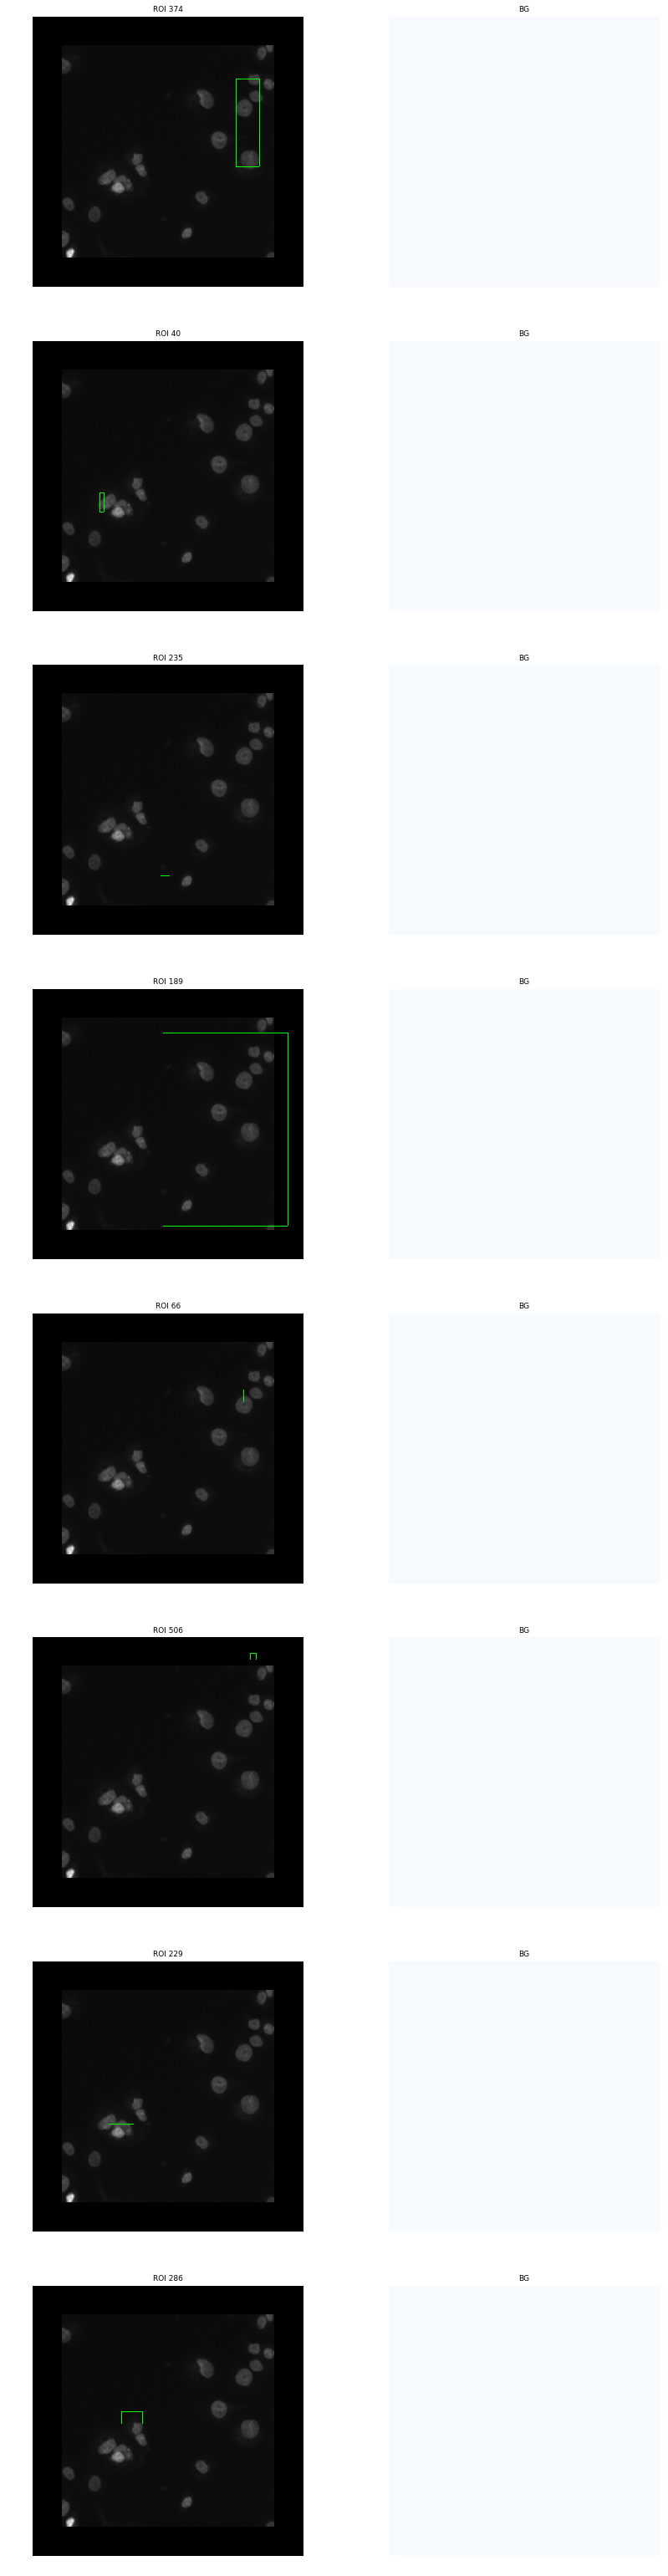

In [33]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=2, cmap="Blues", interpolation="none")

In [17]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 4
    temp_g = modellib.data_generator(
        data_val, config, shuffle=False, random_rois=1000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        [_,image_meta,_,_,_,_,_,_,_], [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{} {:5} {:5.2f}  {}".format(image_meta[0][0], positive_rois, positive_rois/ids.shape[1], ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

0    15  0.03  512
1     9  0.02  512
2     8  0.02  512
3    13  0.03  512
Average percent: 0.02


In [ ]:
print(np.in1d.__doc__)

In [32]:
len([_,_,_,_,_,_,_])

7